In [1327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Flatten, Attention
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [1328]:
df = pd.read_csv('sf_dataset.csv', parse_dates=['date'], index_col=['date', 'time'])
df = df.drop([
    # 'time',
    # 'date',
    # 'pvsim',
    'Lag_24',
    'Lag_25',
    'Lag_48',
    'Lag_72',
    # 'solar_azimuth',
    # 'solar_zenith',
    # 'solar_elevation',
    'solar_time',

    # 'shortwave_radiation',  #
    # 'direct_radiation', #
    # 'diffuse_radiation', #
    # 'direct_normal_irradiance', #

    'weathercode',

    # 'temperature_2m', #
    'dewpoint_2m',

    'relativehumidity_2m',
    'surface_pressure',

    'windspeed_10m',
    'winddirection_10m',

    # 'cloudcover', #
    'cloudcover_low',
    'cloudcover_mid',
    'cloudcover_high',
    'cloud_radiation',

    'precipitation',
    'rain',
    'snowfall',
], axis=1)

print(df.columns)

Index(['Power', 'solar_azimuth', 'solar_zenith', 'solar_elevation',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'temperature_2m', 'cloudcover', 'pvsim'],
      dtype='object')


In [1329]:
# multi_index_df = df.index.to_frame(index=True)
# multi_index_df['day'] = multi_index_df.date.dt.day
# multi_index_df['month'] = multi_index_df.date.dt.month
# multi_index_df['hour'] = pd.to_datetime(multi_index_df['time'], format='%H:%M:%S').dt.hour
# 
# multi_index_df['day_cos'] = np.cos(2 * np.pi * multi_index_df['day']/multi_index_df['day'].max())
# multi_index_df['day_sin'] = np.sin(2 * np.pi * multi_index_df['day']/multi_index_df['day'].max())
# multi_index_df['hour_cos'] = np.cos(2 * np.pi * multi_index_df['hour']/24)
# multi_index_df['hour_sin'] = np.sin(2 * np.pi * multi_index_df['hour']/24)
# multi_index_df['month_cos'] = np.cos(2 * np.pi * multi_index_df['month']/12)
# multi_index_df['month_sin'] = np.sin(2 * np.pi * multi_index_df['month']/12)
# 
# multi_index_df = multi_index_df.drop(['date', 'time'], axis=1)
# 
# for col in ['day_cos', 'day_sin', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin']:
#     df[col] = multi_index_df[col]

In [1330]:
power = df.pop('Power')
df['Power'] = power

# print(df.head(1))
# print(df.tail(1))

In [1331]:
train_df = df[df.index.get_level_values('date') < '2023-03-05'] #2023/02/01
test_df = df[df.index.get_level_values('date') >= '2023-03-05']
print(np.shape(df))
print(np.shape(train_df))
print(np.shape(test_df))

(12816, 11)
(10248, 11)
(2568, 11)


In [1332]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

data_scaled = pd.concat([train_scaled,test_scaled],axis=0)

In [1333]:
look_back = 15*24
horizon = 24

In [1334]:
def prepare_data(data, frame_size, shots):
    X, y = [], []
    for i in range(0, data.shape[0], shots):
        end_ix = i + shots + frame_size
        if end_ix > data.shape[0]:
            break
        X.append(data.iloc[i:end_ix, :].to_numpy()) 
        y.append(data.iloc[end_ix-shots:end_ix, -1].to_numpy())
    return np.array(X), np.array(y)

In [1335]:
x_data,y_data= prepare_data(data_scaled,look_back,horizon)
train_size = x_data.shape[0] - int(2568/24)
X_train = x_data[:train_size,:,:] 
y_train = y_data[:train_size,]

X_test = x_data[train_size:,:,:] 
y_test = y_data[train_size:,]

In [1336]:
X_train[:, -24:, -1] = 0
X_test[:, -24:, -1] = 0

In [1337]:
# print(x_data.shape)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

In [1338]:
class ImprovedAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(ImprovedAttention, self).__init__()
        self.W_q = tf.keras.layers.Dense(units)
        self.W_k = tf.keras.layers.Dense(units)
        self.W_v = tf.keras.layers.Dense(units)
        self.W_o = tf.keras.layers.Dense(units)
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None, return_attention_weights=False):
        q = self.W_q(inputs)
        k = self.W_k(inputs)
        v = self.W_v(inputs)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # if mask is not None:
        #     scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = self.W_o(output)
        
        if return_attention_weights:
            return self.layer_norm(output), attention_weights  # Return output and attention weights  + inputs
        return output #self.layer_norm(output)  # Residual connection    + inputs

In [1339]:
def build_attention_visualization_model(T, D):
    inputs = Input(shape=(T, D))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    attention_output, attention_weights = ImprovedAttention(100)(x, return_attention_weights=True)
    model = Model(inputs=inputs, outputs=[attention_output, attention_weights])
    return model

In [1340]:
def plot_attention_weights(model, input_sample, epoch):
    _, attention_weights = model.predict(input_sample)
    attention_weights = attention_weights[0]  
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention_weights, cmap="viridis")
    plt.title(f"Attention Weights, epoch={epoch}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

In [1341]:
def build_model(T, D):
    inputs = Input(shape=(T, D))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    # x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = ImprovedAttention(100)(x) 
    x = GlobalAveragePooling1D()(x)
    x = Dense(120)(x) #120
    x = Dense(60)(x) # 60
    x = Dense(120)(x) #120
    x = Dense(60)(x)  # 60
    x = Dense(24)(x)  
    model = Model(inputs=inputs, outputs=x)
    return model

In [1342]:
# def build_model2(T, D):
#     inputs = Input(shape=(T, D))
#     x = LSTM(50, return_sequences=True)(inputs) 
#     x = LSTM(50, return_sequences=False)(x)
#     x = Dense(120)(x)
#     x = Dense(60)(x)
#     x = Dense(120)(x)
#     x = Dense(60)(x)
#     x = Dense(24)(x)
#     model = Model(inputs=inputs, outputs=x)
#     return model

In [1343]:
model = build_model(look_back+horizon, X_train.shape[2])

In [1344]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')
epochs = 200
batch_size = 32
learning_rate = 5e-4
adam_optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss="mse")
# model.compile(optimizer="adam", loss="mse")

In [1345]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2) # callbacks=[early_stopping]) 

Epoch 1/200
11/11 [==============================] - 6s 252ms/step - loss: 0.0434 - val_loss: 0.0118
Epoch 2/200
11/11 [==============================] - 2s 177ms/step - loss: 0.0179 - val_loss: 0.0061
Epoch 3/200
11/11 [==============================] - 2s 181ms/step - loss: 0.0154 - val_loss: 0.0048
Epoch 4/200
11/11 [==============================] - 2s 178ms/step - loss: 0.0142 - val_loss: 0.0044
Epoch 5/200
11/11 [==============================] - 2s 174ms/step - loss: 0.0139 - val_loss: 0.0045
Epoch 6/200
11/11 [==============================] - 2s 179ms/step - loss: 0.0150 - val_loss: 0.0048
Epoch 7/200
11/11 [==============================] - 2s 177ms/step - loss: 0.0137 - val_loss: 0.0047
Epoch 8/200
11/11 [==============================] - 2s 178ms/step - loss: 0.0133 - val_loss: 0.0041
Epoch 9/200
11/11 [==============================] - 2s 174ms/step - loss: 0.0138 - val_loss: 0.0044
Epoch 10/200
11/11 [==============================] - 2s 184ms/step - loss: 0.0133 - val_lo

In [1346]:
# model2 = build_model2(look_back+horizon, X_train.shape[2])
# # early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# model2.compile(optimizer="adam", loss="mse")
# history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)  # , callbacks=[early_stopping]

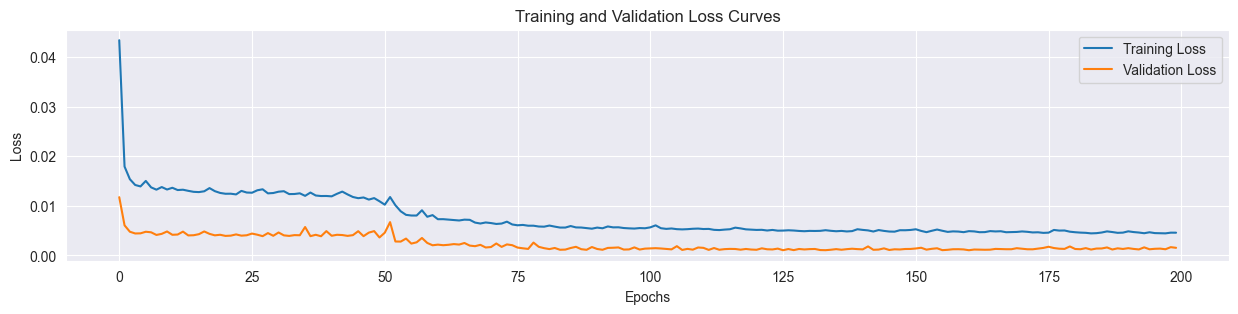

In [1360]:
plt.figure(figsize=(15, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1361]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

13/13 [==============================] - 1s 73ms/step


In [1362]:
y_pred[y_pred<0]= 0
y_pred[y_test==0]=0
# print(np.shape(y_pred))
y_test = np.squeeze(y_test)
indices = np.nonzero(y_test)[0]
y_test_nz = y_test [indices]
y_pred_nz = y_pred [indices]

In [1363]:
# y_pred_tf= y_pred [1:,:]
y_pred_tf= y_pred
y_pred_shp  = y_pred_tf.reshape(-1,1)
result_df= test_scaled.copy()
# print(result_df.shape)
result_df['Power'] = y_pred_shp
# print(np.shape(result_df))
result_df  = scaler.inverse_transform(result_df)
preds = result_df[:, -1]
result_df  = pd.DataFrame(result_df)
result_df.to_csv('result_saed.csv')
indices = np.nonzero(test_df['Power'])[0]
act_nz = test_df['Power'].iloc[indices]
preds_nz = preds[indices]

In [1364]:
def mean_absolute_percentage(y_true, y_pred):
    ymean = np.mean(y_true)
    ape = [abs(y_true[i] - y_pred[i]) for i in range(len(y_true))]
    mape = (sum(ape) / len(y_true)) * 100
    mape = mape / ymean
    return mape

In [1365]:
print('train performance:')
print('\tnRmse:', mean_squared_error(y_train, y_pred_train, squared=False)/np.max(y_train))
print('\tMAPE:', np.mean(mean_absolute_percentage(y_train, y_pred_train)))
print('\tMAE:',  mean_absolute_error(y_train, y_pred_train)/np.max(y_train))
# print('\tR2:',   r2_score(y_train, y_pred_train)).

print('pvsim performance:')
print('\tnRmse:', mean_squared_error(test_df['Power'].values, test_df['pvsim'].values, squared=False)/np.max(test_df['Power'].values))
print('\tMAPE:', np.mean(mean_absolute_percentage(test_df['Power'].values, test_df['pvsim'].values)))
print('\tnMAE:',  mean_absolute_error(test_df['Power'].values, test_df['pvsim'].values)/np.max(test_df['Power']))
print('\tR2:',   r2_score(test_df['Power'].values, test_df['pvsim'].values))

print('ml performance:')
print('\tnRmse:', mean_squared_error(test_df['Power'], preds, squared=False)/np.max(test_df['Power']))
print('\tMAPE:', np.mean(mean_absolute_percentage(test_df['Power'], preds)))
print('\tnMAE:',  mean_absolute_error(test_df['Power'], preds)/np.max(test_df['Power']))
print('\tR2:',   r2_score(test_df['Power'], preds))

print('ml_nz performance:')
print('\tnRmse:', mean_squared_error(act_nz, preds_nz, squared=False)/np.max(act_nz))
print('\tMAPE:', np.mean(mean_absolute_percentage(act_nz, preds_nz)))
print('\tnMAE:',  mean_absolute_error(act_nz, preds_nz)/np.max(act_nz))
print('\tR2:',   r2_score(act_nz, preds_nz))

print('scaled test performance:')
print('\tnRmse:', mean_squared_error(y_test_nz, y_pred_nz, squared=False)/np.max(y_test_nz))
print('\tMAPE:', np.mean(mean_absolute_percentage(y_test_nz, y_pred_nz)))
print('\tMAE:',  mean_absolute_error(y_test_nz, y_pred_nz)/np.max(y_test_nz))
print('\tR2:',   r2_score(y_test_nz, y_pred_nz))

# r2score = []    
# for i in range(np.shape(y_pred)[0]):
#      r2score.append(r2_score(y_pred[i,:], y_test[i,:]))
# print('\tR2:', np.mean(r2score))

train performance:
	nRmse: 0.043947637620769725
	MAPE: 27.431544591963814
	MAE: 0.031082906778982577
pvsim performance:
	nRmse: 0.09606815064473202
	MAPE: 26.28810539865892
	nMAE: 0.05171611044355269
	R2: 0.8712075944408133
ml performance:
	nRmse: 0.09468341112761393
	MAPE: 24.601199767748316
	nMAE: 0.04839749175296906
	R2: 0.8748936984267649
ml_nz performance:
	nRmse: 0.12191178679676713
	MAPE: 24.601199767748316
	nMAE: 0.08023548019472211
	R2: 0.8059484329071382
scaled test performance:
	nRmse: 0.06446738510287843
	MAPE: 23.775384877206495
	MAE: 0.048728377879347126
	R2: -1.4149219456894244


C:\Users\Hossein\AppData\Local\Temp\ipykernel_17200\1737368977.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ape = [abs(y_true[i] - y_pred[i]) for i in range(len(y_true))]
C:\Users\Hossein\AppData\Local\Temp\ipykernel_17200\1737368977.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ape = [abs(y_true[i] - y_pred[i]) for i in range(len(y_true))]


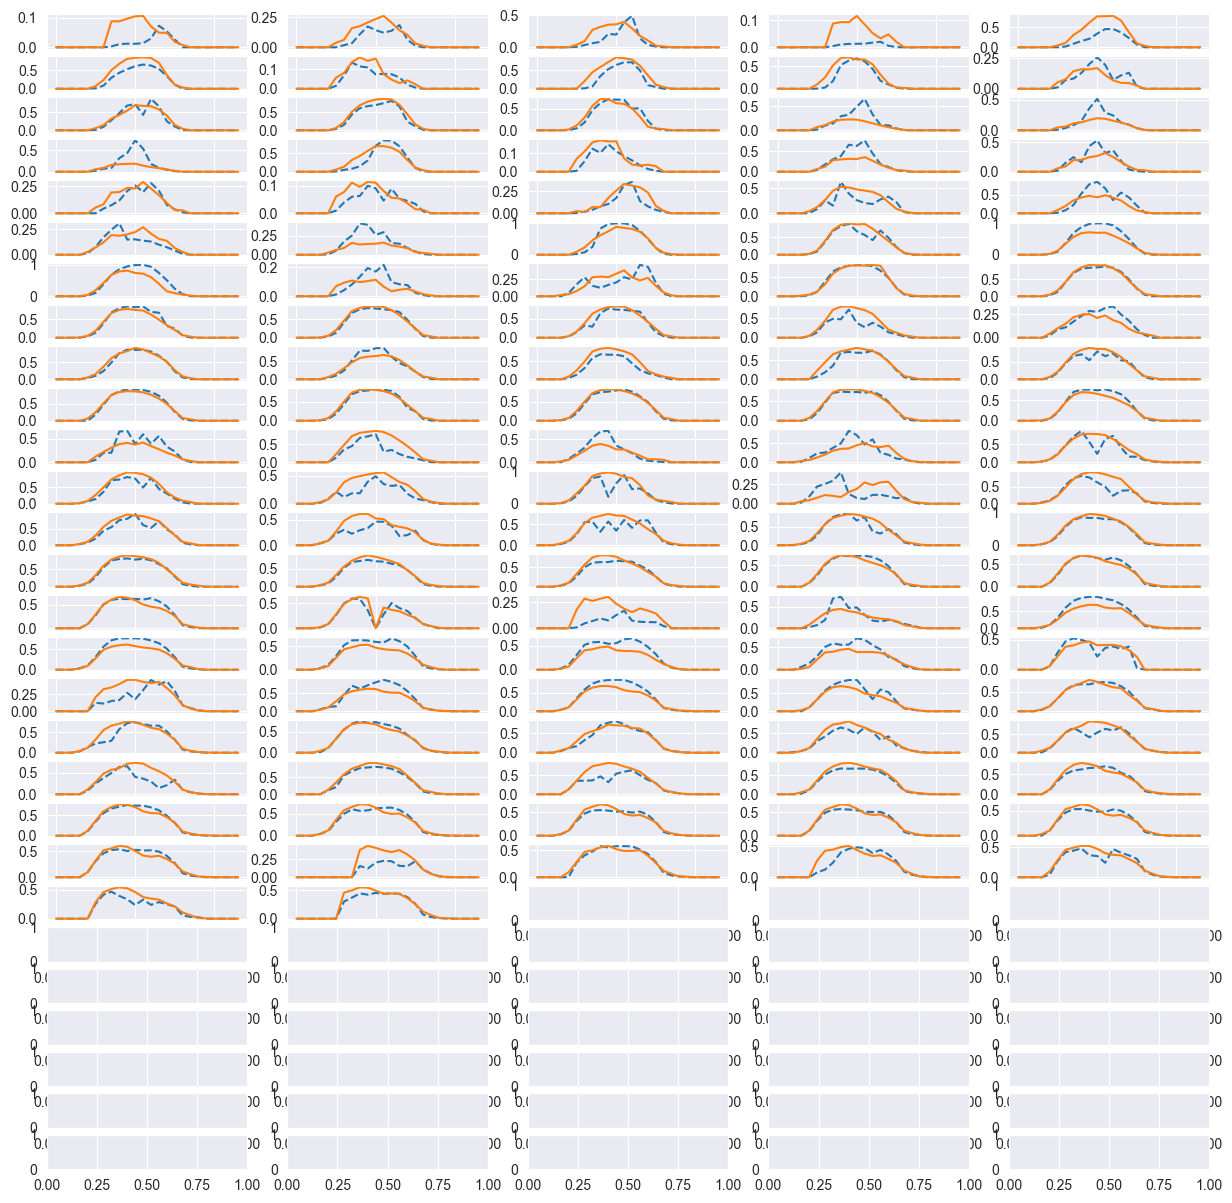

In [1353]:
fig,ax=plt.subplots(28,5, figsize=(15,15))
for num in range(y_test.shape[0]):
    i,j = divmod(num,5) 
    ax[i,j].plot(y_test[num,:], '--', label='actual')
    ax[i,j].plot(y_pred[num,:], label='prediction')
    # ax[i,j].legend()
    # ax[i,j].plot(y_pred2[i,:], label='prediction2')
# plt.tight_layout()
plt.show()

13/13 [==============================] - 2s 74ms/step


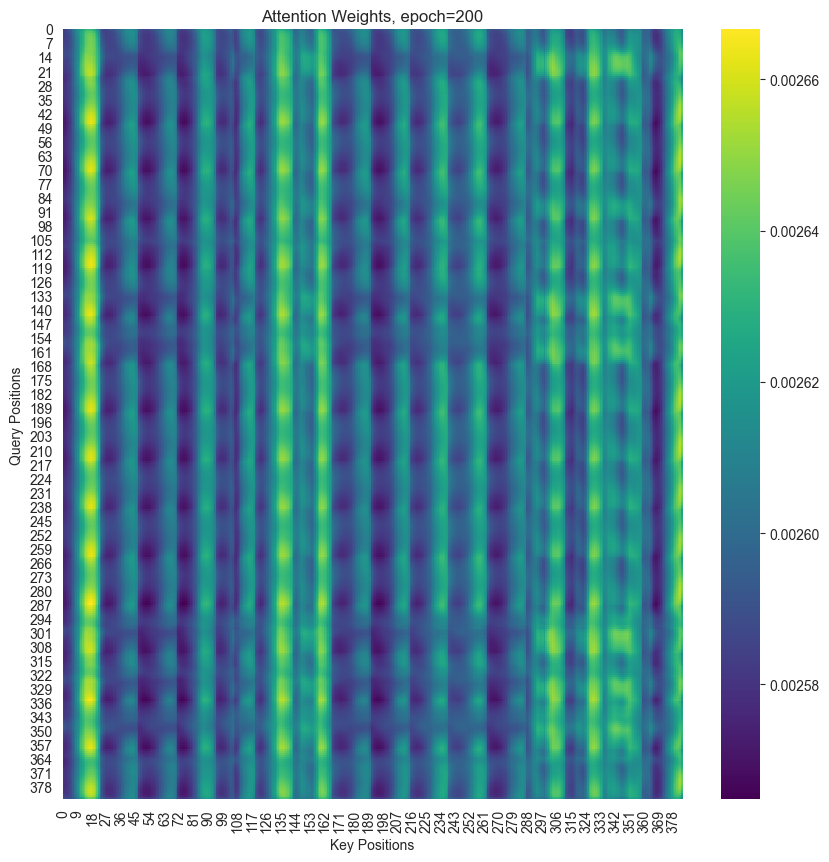

In [1354]:
vis_model = build_attention_visualization_model(look_back+horizon, X_train.shape[2])
plot_attention_weights(vis_model, X_train, epoch= 200)

In [1355]:
# fig = plt.figure(figsize=(15,5))
# plt.plot(preds[:800])
# plt.plot(test_df['Power'].values[:800])
# plt.show()

In [1356]:
# y_pred2 = model2.predict(X_test)
# y_pred[y_pred<0]= 0
# y_pred[y_test==0]=0
# # y_test = np.squeeze(y_test)
# 
# # indices = np.nonzero(y_test)[0]
# 
# # y_test_nz = y_test [indices]
# y_pred_nz2 = y_pred2 [indices]

In [1357]:
# print('test performance:')
# print('\tRmse:', mean_squared_error(y_test_nz, y_pred_nz2, squared=True))
# print('\tMAPE:', np.mean(mean_absolute_percentage(y_test_nz, y_pred_nz2)))
# print('\tMAE:', mean_absolute_error(y_test_nz, y_pred_nz2))
# # print('\tr2:', r2_score(y_test_nz, y_pred_nz))
# 
# r2score = []    
# for i in range(np.shape(y_pred2)[0]):
#      r2score.append(r2_score(y_pred2[i,:], y_test[i,:]))
# print('\tR2:', np.mean(r2score))

In [1358]:
# plt.figure(figsize=(3, 3))
# plt.plot(history2.history['loss'], label='Training Loss')
# plt.plot(history2.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss Curves')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [1359]:
# # print(y_test.shape)
# # print(y_pred.shape)
# 
# X_pred=X_test
# for i in range(X_test.shape[0]):
#     X_test[i,-24:, -1] = y_test[i,:]
#     X_pred[i,-24:, -1] = y_pred[i,:]
# 
# print(X_test.shape)
# print(X_pred.shape)
# 
# X_test_nw = [] 
# X_pred_nw = []
# for i in range(0, X_test.shape[0], 24):
#     X_test_nw[i,:] = X_test[i,:24, :]
#     X_pred_nw[i,:] = X_pred[i,:24, :]
#     
# # X_test = scaler.inverse_transform(X_test[-1,-24:,:])
# # X_pred = scaler.inverse_transform(X_pred[-1,-24:,:])
# 
# X_test_sc = scaler.inverse_transform(X_test_nw)
# X_pred_sc = scaler.inverse_transform(X_pred_nw)
# 
# # for i in range(X_test.shape[0]):
# #     y_test[i,:] = X_test[i,-24:, -1]
# #     y_pred[i,:] = X_pred[i,-24:, -1]